# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- <b>Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?</b><br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [1]:
import json
import pandas as pd
from numpy import NaN
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

### Preprocessing

In [4]:
for events in events_df.values():
    events['tags'] = events['tags'].apply(extract_tags)

### Italian pass chains analysis

In [5]:
italian_events = events_df['Italy']

In [6]:
passes_before_shot = get_passes_before_shot(italian_events)
italian_passes_counts = count_passes_before_shot(passes_before_shot)
italian_passes_counts['duel'] = True

In [7]:
goals = italian_events[italian_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [8]:
passes_before_goal = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

In [9]:
italian_goals_passes_counts = count_passes_before_shot(passes_before_goal)
italian_goals_passes_counts['duel'] = True

I also remove these events to compare how the results change:
- >1,11,Duel,Ground attacking duel
- >1,12,Duel,Ground defending duel
- >1,13,Duel,Ground loose ball duel

In [10]:
italian_events = italian_events[(italian_events['eventId'] != 1) & (~italian_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

In [11]:
passes_before_shot_no_duel = get_passes_before_shot(italian_events)
italian_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

In [12]:
italian_passes_counts_no_duels['duel'] = False

In [13]:
goals = italian_events[italian_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [14]:
passes_before_goal_no_duel = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

In [15]:
italian_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
italian_goals_passes_counts_no_duels['duel'] = False

In [16]:
italian_passes_counts = pd.concat([italian_passes_counts, italian_passes_counts_no_duels])
italian_goals_passes_counts = pd.concat([italian_goals_passes_counts, italian_goals_passes_counts_no_duels])

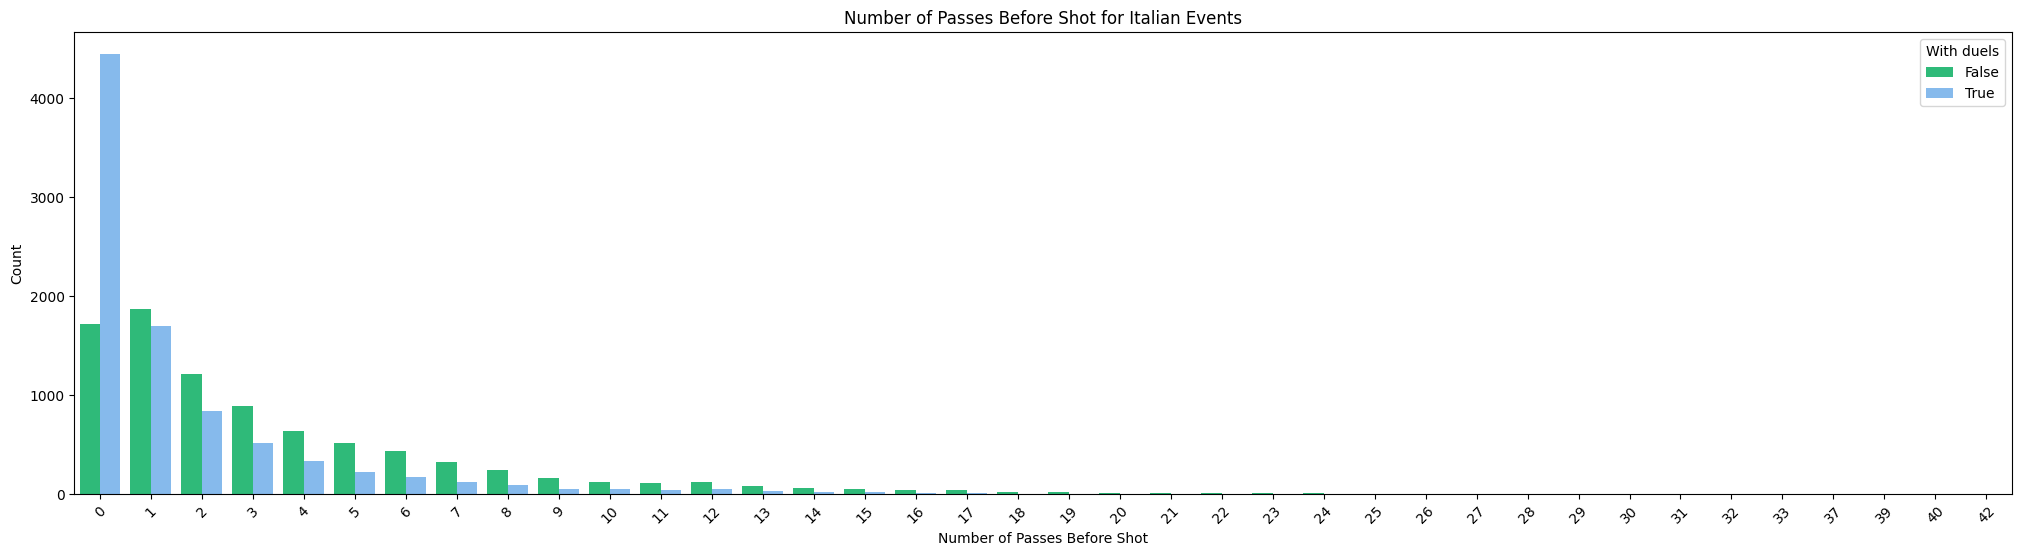

In [17]:
plot_histogram_pass_chain(italian_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for Italian Events')

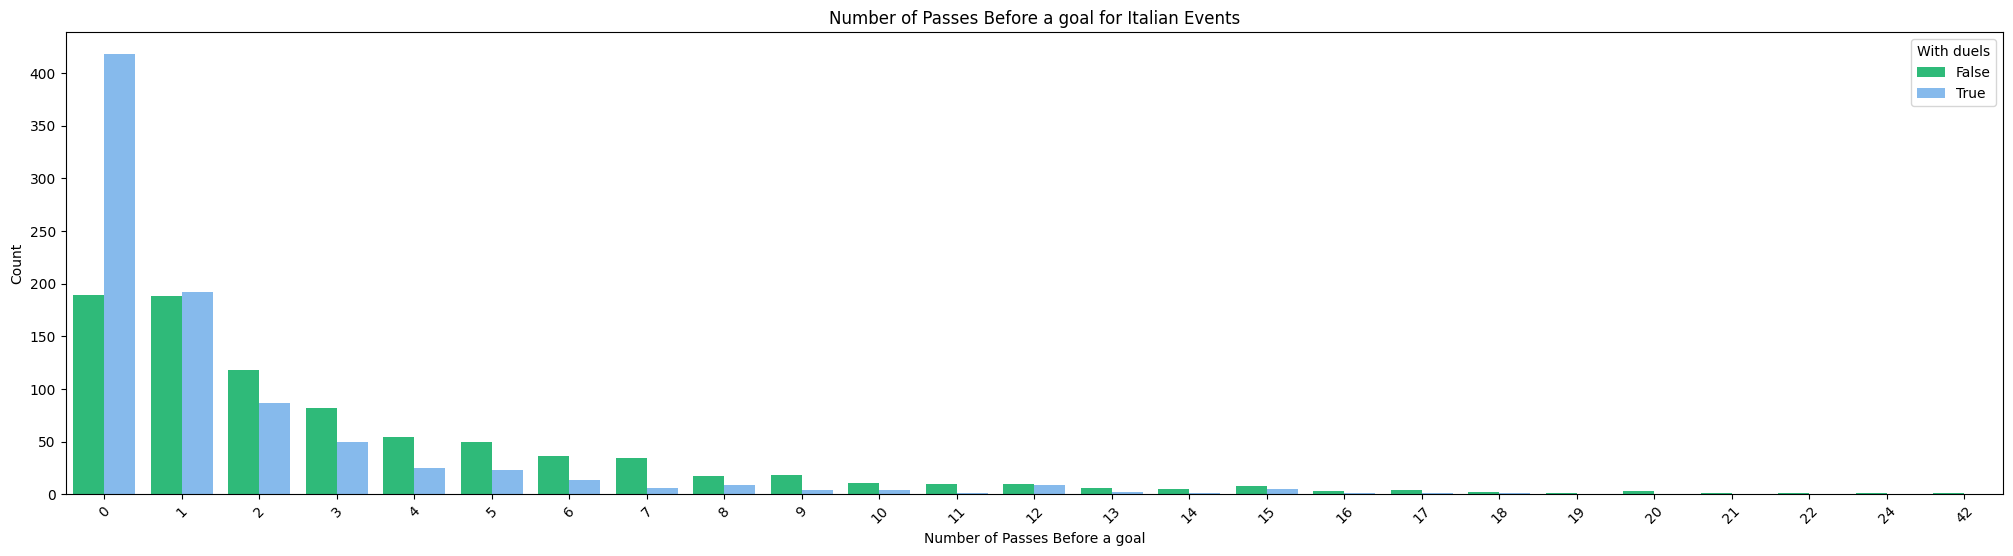

In [18]:
plot_histogram_pass_chain(italian_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for Italian Events')

### English pass chains analysis

In [19]:
english_events = events_df['England']

In [20]:
passes_before_shot = get_passes_before_shot(english_events)
english_passes_counts = count_passes_before_shot(passes_before_shot)
english_passes_counts['duel'] = True

In [21]:
goals = english_events[english_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [22]:
passes_before_goal = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

In [23]:
english_goals_passes_counts = count_passes_before_shot(passes_before_goal)
english_goals_passes_counts['duel'] = True

I also remove these events to compare how the results change:
- >1,11,Duel,Ground attacking duel
- >1,12,Duel,Ground defending duel
- >1,13,Duel,Ground loose ball duel

In [24]:
english_events = english_events[(english_events['eventId'] != 1) & (~english_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

In [25]:
passes_before_shot_no_duel = get_passes_before_shot(english_events)
english_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

In [26]:
english_passes_counts_no_duels['duel'] = False

In [27]:
goals = english_events[english_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [28]:
passes_before_goal_no_duel = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

In [29]:
english_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
english_goals_passes_counts_no_duels['duel'] = False

In [30]:
english_passes_counts = pd.concat([english_passes_counts, english_passes_counts_no_duels])
english_goals_passes_counts = pd.concat([english_goals_passes_counts, english_goals_passes_counts_no_duels])

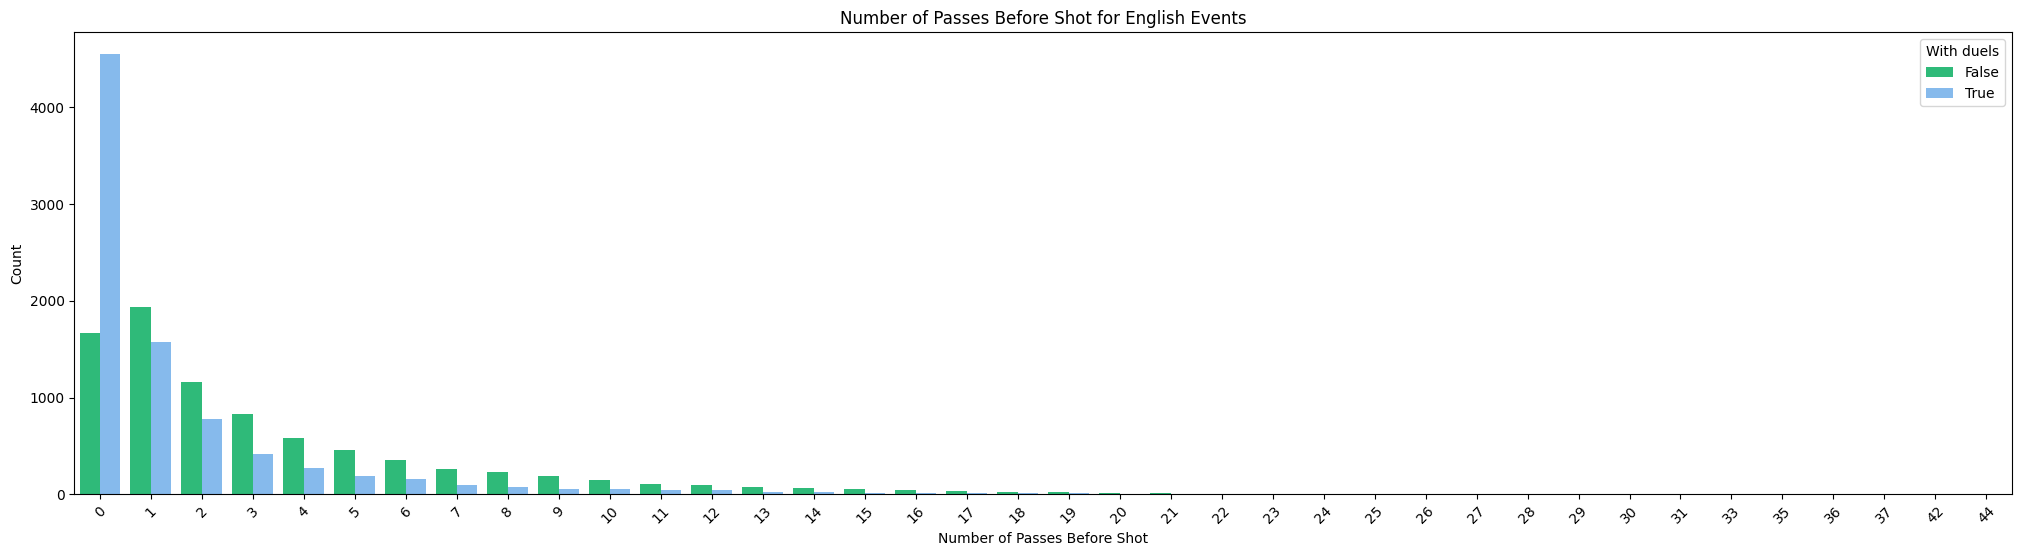

In [31]:
plot_histogram_pass_chain(english_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for English Events')

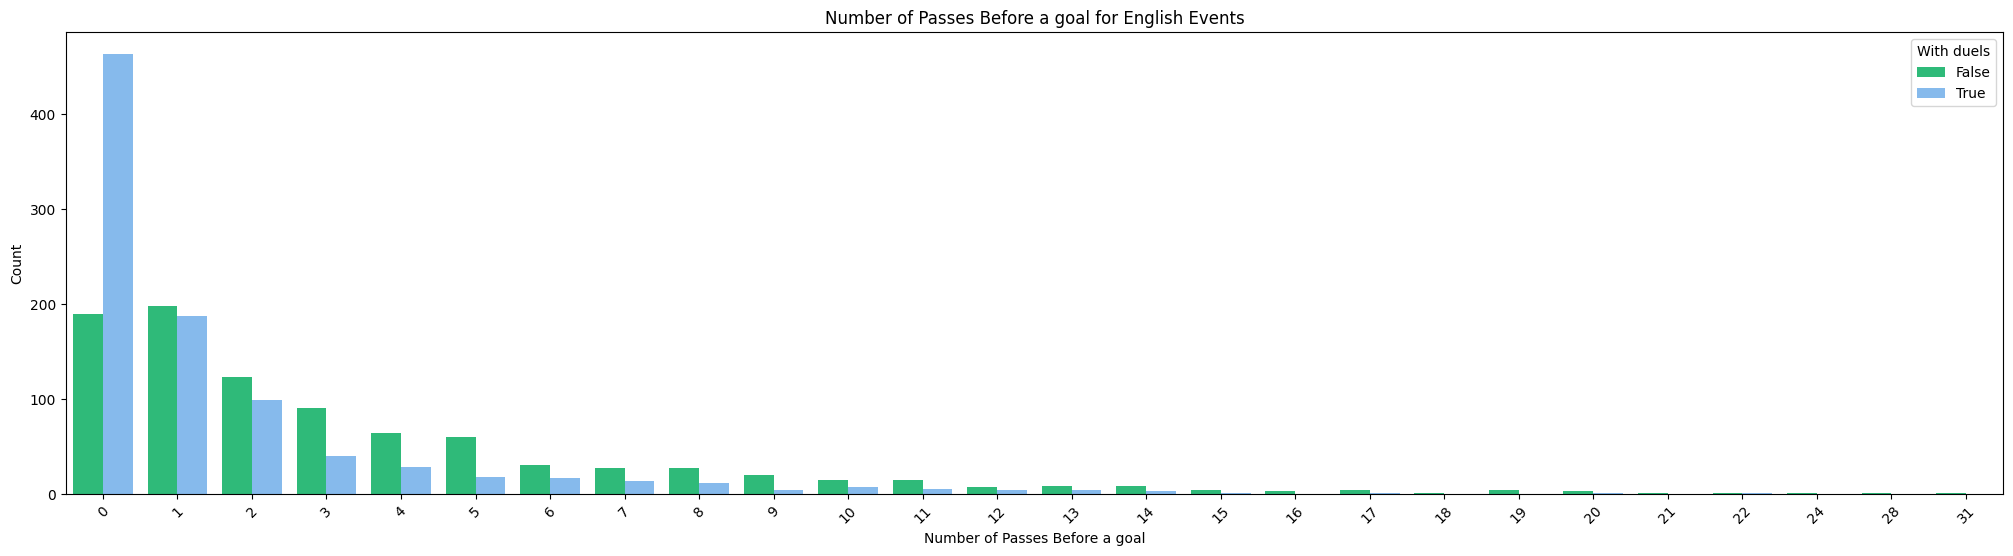

In [32]:
plot_histogram_pass_chain(english_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for English Events')

### Spanish pass chain analysis

In [33]:
spanish_events = events_df['Spain']

In [34]:
passes_before_shot = get_passes_before_shot(spanish_events)
spanish_passes_counts = count_passes_before_shot(passes_before_shot)
spanish_passes_counts['duel'] = True

In [35]:
goals = spanish_events[spanish_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [36]:
passes_before_goal = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

In [37]:
spanish_goals_passes_counts = count_passes_before_shot(passes_before_goal)
spanish_goals_passes_counts['duel'] = True

I also remove these events to compare how the results change:
- >1,11,Duel,Ground attacking duel
- >1,12,Duel,Ground defending duel
- >1,13,Duel,Ground loose ball duel

In [38]:
spanish_events = spanish_events[(spanish_events['eventId'] != 1) & (~spanish_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

In [39]:
passes_before_shot_no_duel = get_passes_before_shot(spanish_events)
spanish_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

In [40]:
spanish_passes_counts_no_duels['duel'] = False

In [41]:
goals = spanish_events[spanish_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [42]:
passes_before_goal_no_duel = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

In [43]:
spanish_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
spanish_goals_passes_counts_no_duels['duel'] = False

In [44]:
spanish_passes_counts = pd.concat([spanish_passes_counts, spanish_passes_counts_no_duels])
spanish_goals_passes_counts = pd.concat([spanish_goals_passes_counts, spanish_goals_passes_counts_no_duels])

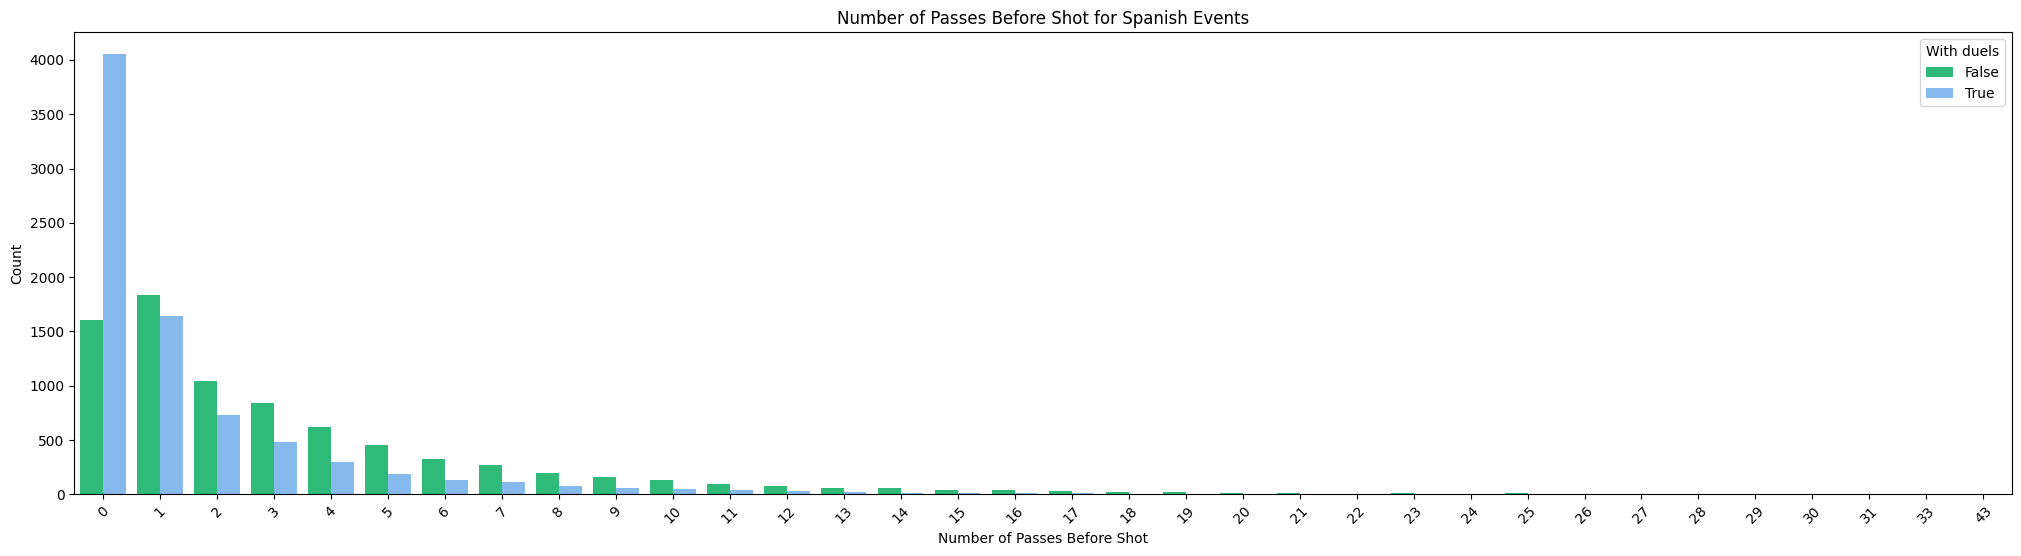

In [45]:
plot_histogram_pass_chain(spanish_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for Spanish Events')

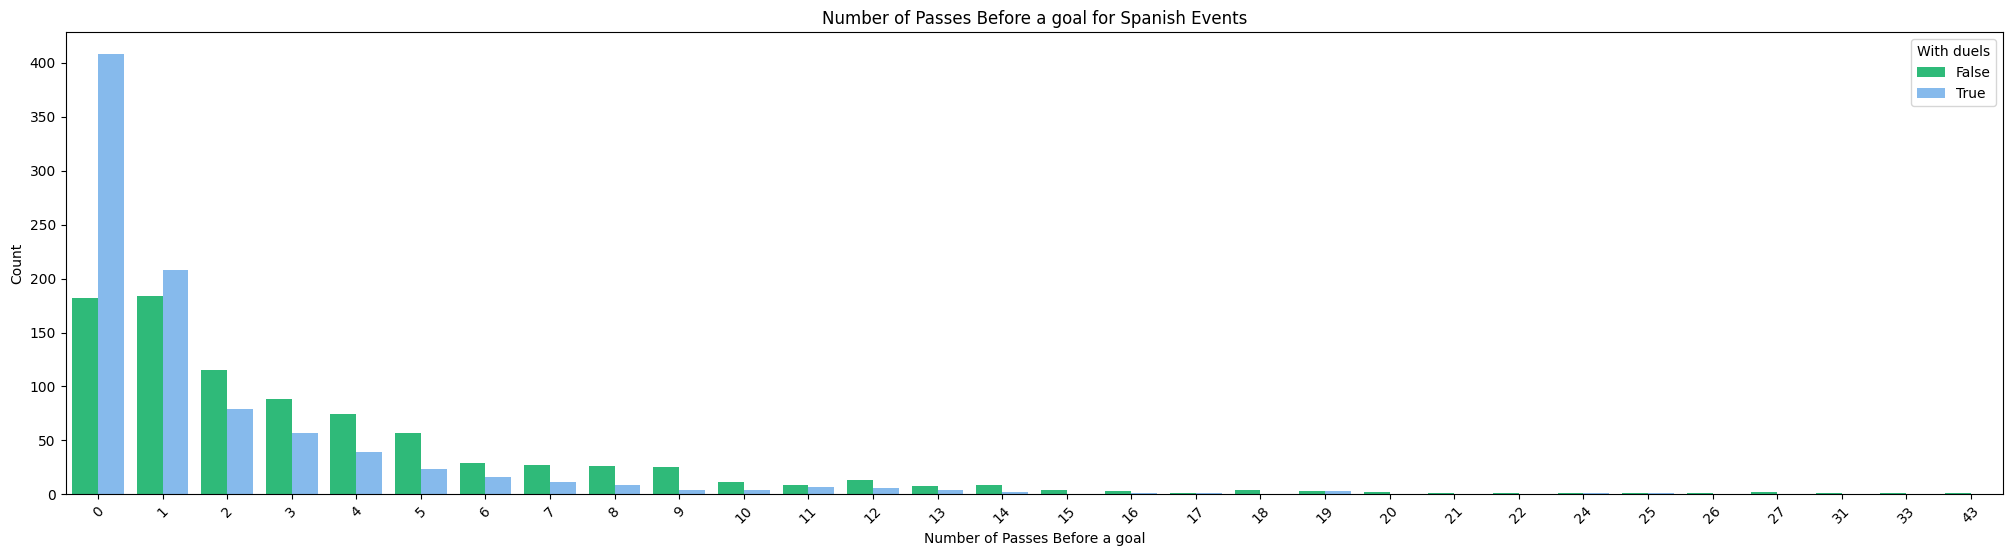

In [46]:
plot_histogram_pass_chain(spanish_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for Spanish Events')

### German pass chain analysis

In [47]:
german_events = events_df['Germany']

In [48]:
passes_before_shot = get_passes_before_shot(german_events)
german_passes_counts = count_passes_before_shot(passes_before_shot)
german_passes_counts['duel'] = True

In [49]:
goals = german_events[german_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [50]:
passes_before_goal = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

In [51]:
german_goals_passes_counts = count_passes_before_shot(passes_before_goal)
german_goals_passes_counts['duel'] = True

I also remove these events to compare how the results change:
- >1,11,Duel,Ground attacking duel
- >1,12,Duel,Ground defending duel
- >1,13,Duel,Ground loose ball duel

In [52]:
german_events = german_events[(german_events['eventId'] != 1) & (~german_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

In [53]:
passes_before_shot_no_duel = get_passes_before_shot(german_events)
german_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

In [54]:
german_passes_counts_no_duels['duel'] = False

In [55]:
goals = german_events[german_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [56]:
passes_before_goal_no_duel = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

In [57]:
german_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
german_goals_passes_counts_no_duels['duel'] = False

In [58]:
german_passes_counts = pd.concat([german_passes_counts, german_passes_counts_no_duels])
german_goals_passes_counts = pd.concat([german_goals_passes_counts, german_goals_passes_counts_no_duels])

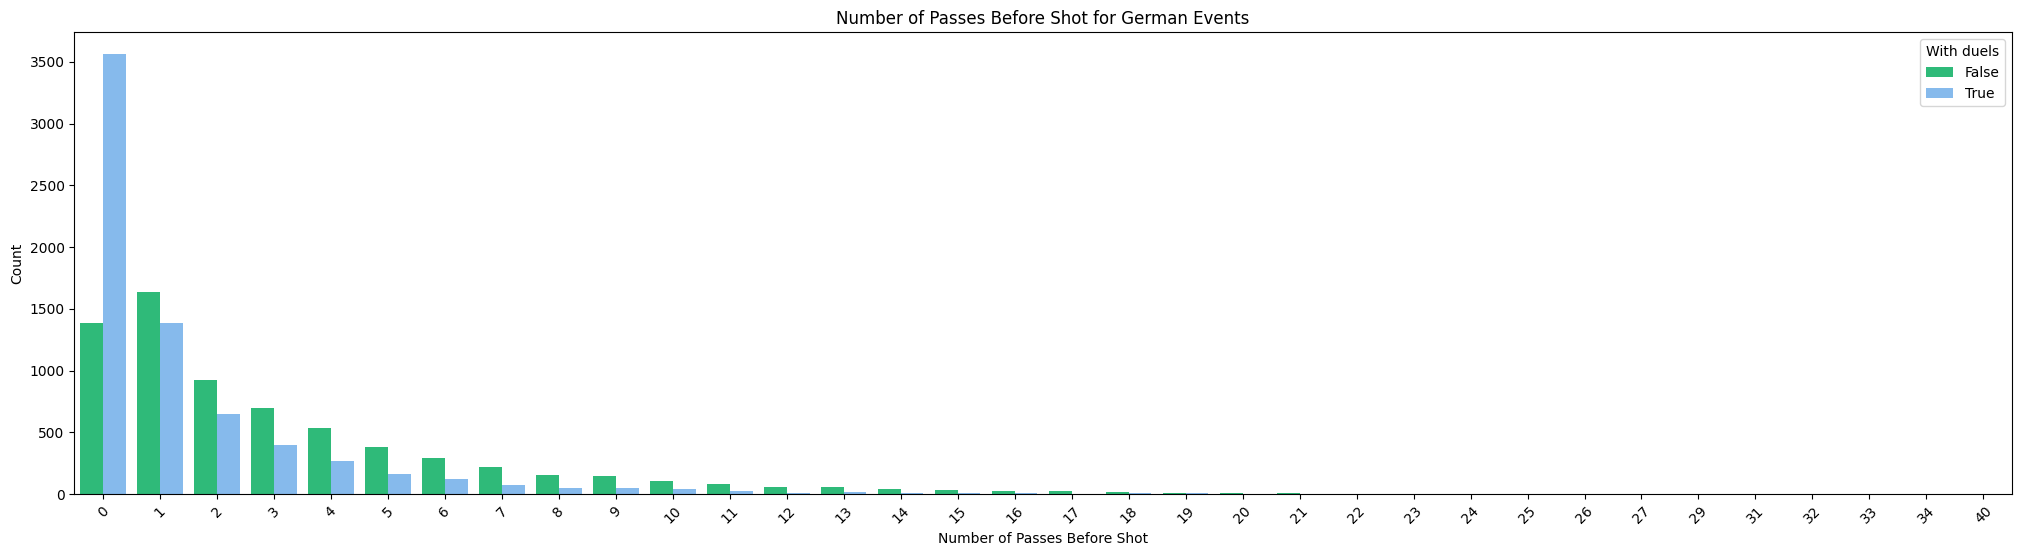

In [59]:
plot_histogram_pass_chain(german_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for German Events')

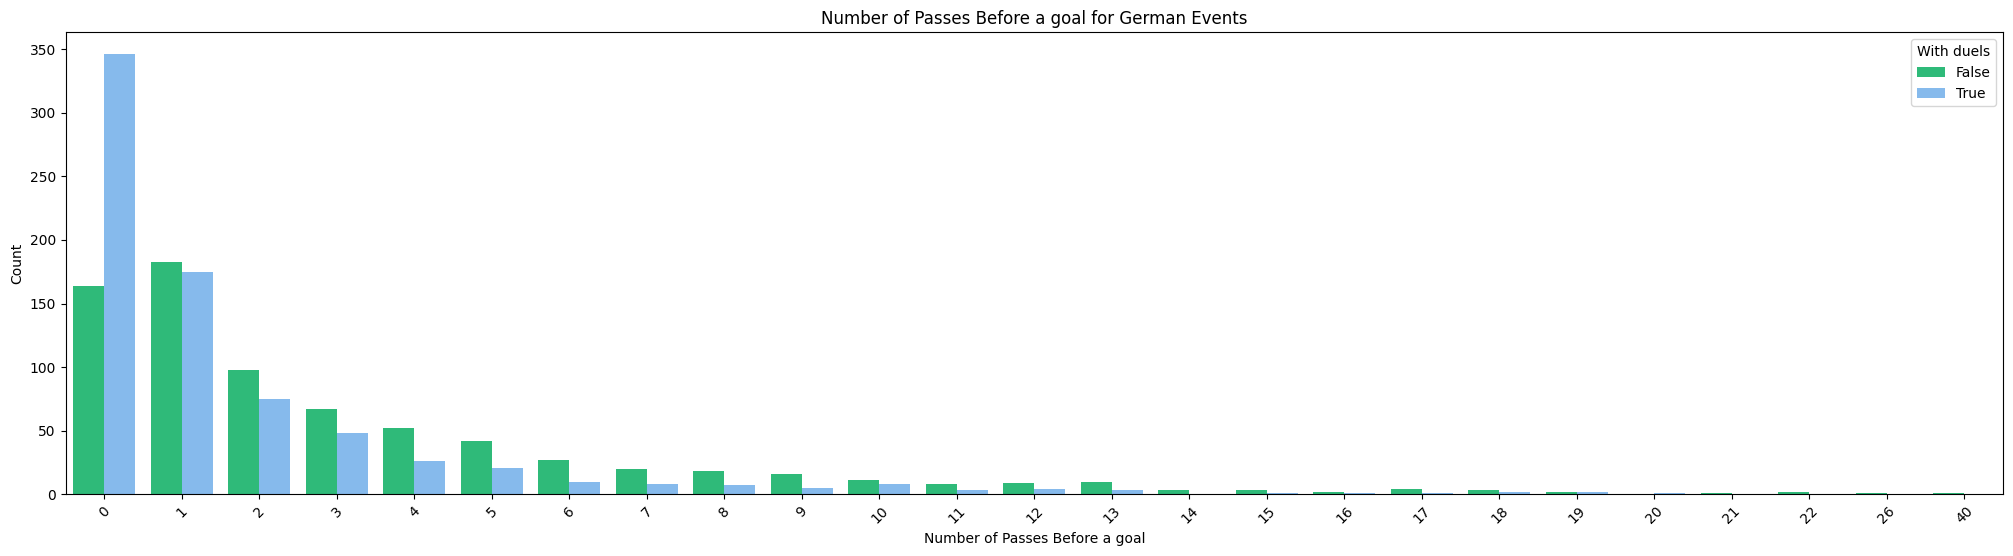

In [60]:
plot_histogram_pass_chain(german_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for German Events')

### French pass chain analysis

In [61]:
french_events = events_df['France']

In [62]:
passes_before_shot = get_passes_before_shot(french_events)
french_passes_counts = count_passes_before_shot(passes_before_shot)
french_passes_counts['duel'] = True

In [63]:
goals = french_events[french_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [64]:
passes_before_goal = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

In [65]:
french_goals_passes_counts = count_passes_before_shot(passes_before_goal)
french_goals_passes_counts['duel'] = True

I also remove these events to compare how the results change:
- >1,11,Duel,Ground attacking duel
- >1,12,Duel,Ground defending duel
- >1,13,Duel,Ground loose ball duel

In [66]:
french_events = french_events[(french_events['eventId'] != 1) & (~french_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

In [67]:
passes_before_shot_no_duel = get_passes_before_shot(french_events)
french_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

In [68]:
french_passes_counts_no_duels['duel'] = False

In [69]:
goals = french_events[french_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [70]:
passes_before_goal_no_duel = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

In [71]:
french_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
french_goals_passes_counts_no_duels['duel'] = False

In [72]:
french_passes_counts = pd.concat([french_passes_counts, french_passes_counts_no_duels])
french_goals_passes_counts = pd.concat([french_goals_passes_counts, french_goals_passes_counts_no_duels])

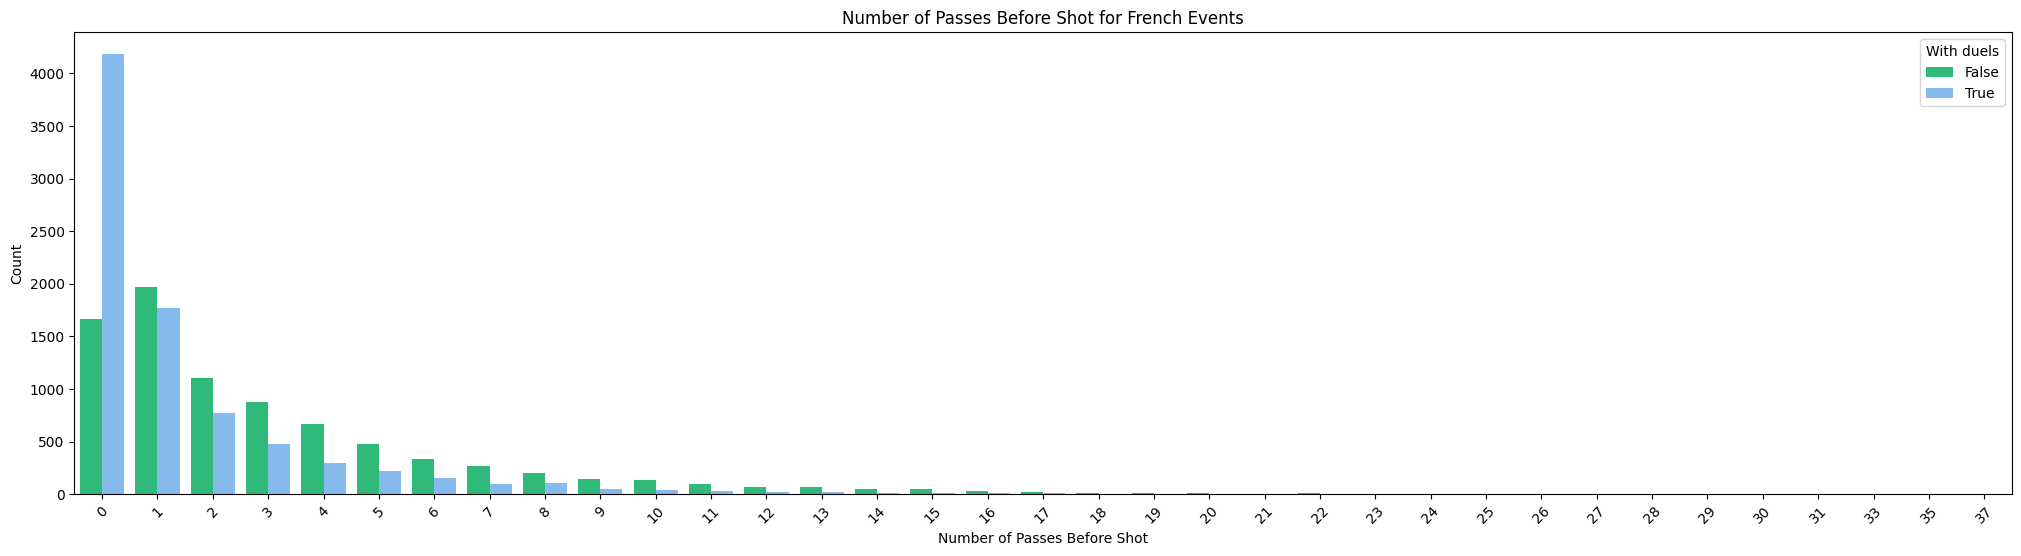

In [73]:
plot_histogram_pass_chain(french_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for French Events')

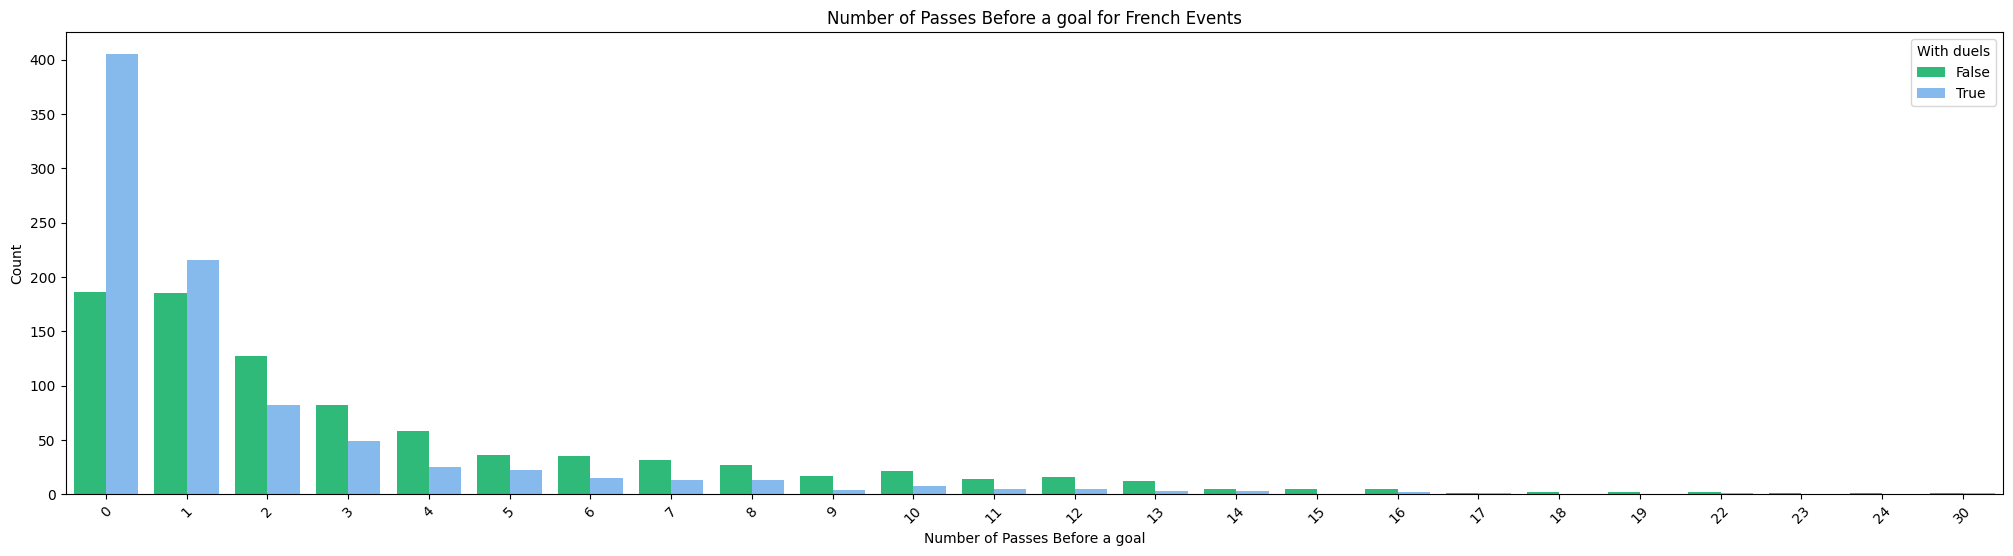

In [74]:
plot_histogram_pass_chain(french_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for French Events')

### European Championship pass chain analysis

In [75]:
european_events = events_df['European_Championship']

In [76]:
passes_before_shot = get_passes_before_shot(european_events)
european_passes_counts = count_passes_before_shot(passes_before_shot)
european_passes_counts['duel'] = True

In [77]:
goals = european_events[european_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [78]:
passes_before_goal = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

In [79]:
european_goals_passes_counts = count_passes_before_shot(passes_before_goal)
european_goals_passes_counts['duel'] = True

I also remove these events to compare how the results change:
- >1,11,Duel,Ground attacking duel
- >1,12,Duel,Ground defending duel
- >1,13,Duel,Ground loose ball duel

In [80]:
european_events = european_events[(european_events['eventId'] != 1) & (~european_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

In [81]:
passes_before_shot_no_duel = get_passes_before_shot(european_events)
european_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

In [82]:
european_passes_counts_no_duels['duel'] = False

In [83]:
goals = european_events[european_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [84]:
passes_before_goal_no_duel = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

In [85]:
european_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
european_goals_passes_counts_no_duels['duel'] = False

In [86]:
european_passes_counts = pd.concat([european_passes_counts, european_passes_counts_no_duels])
european_goals_passes_counts = pd.concat([european_goals_passes_counts, european_goals_passes_counts_no_duels])

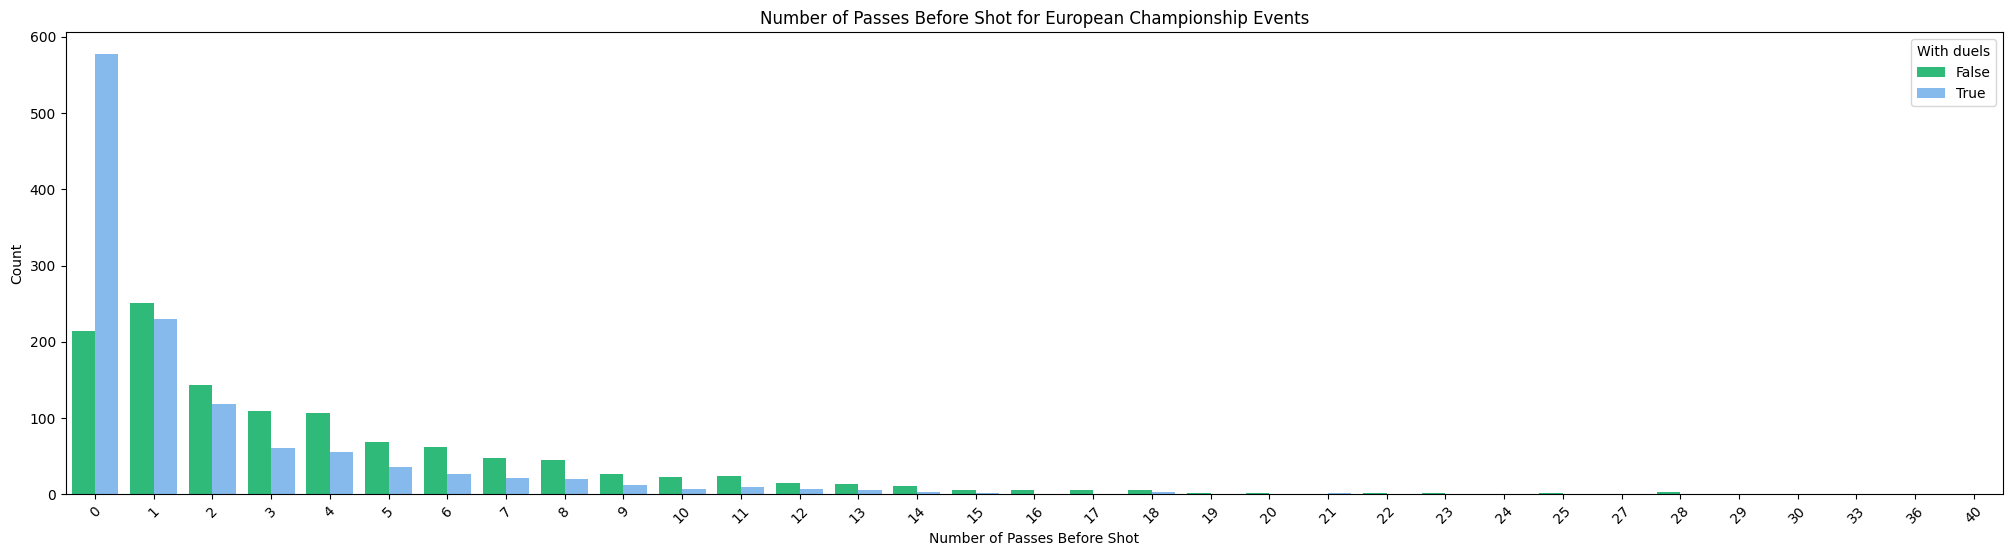

In [87]:
plot_histogram_pass_chain(european_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for European Championship Events')

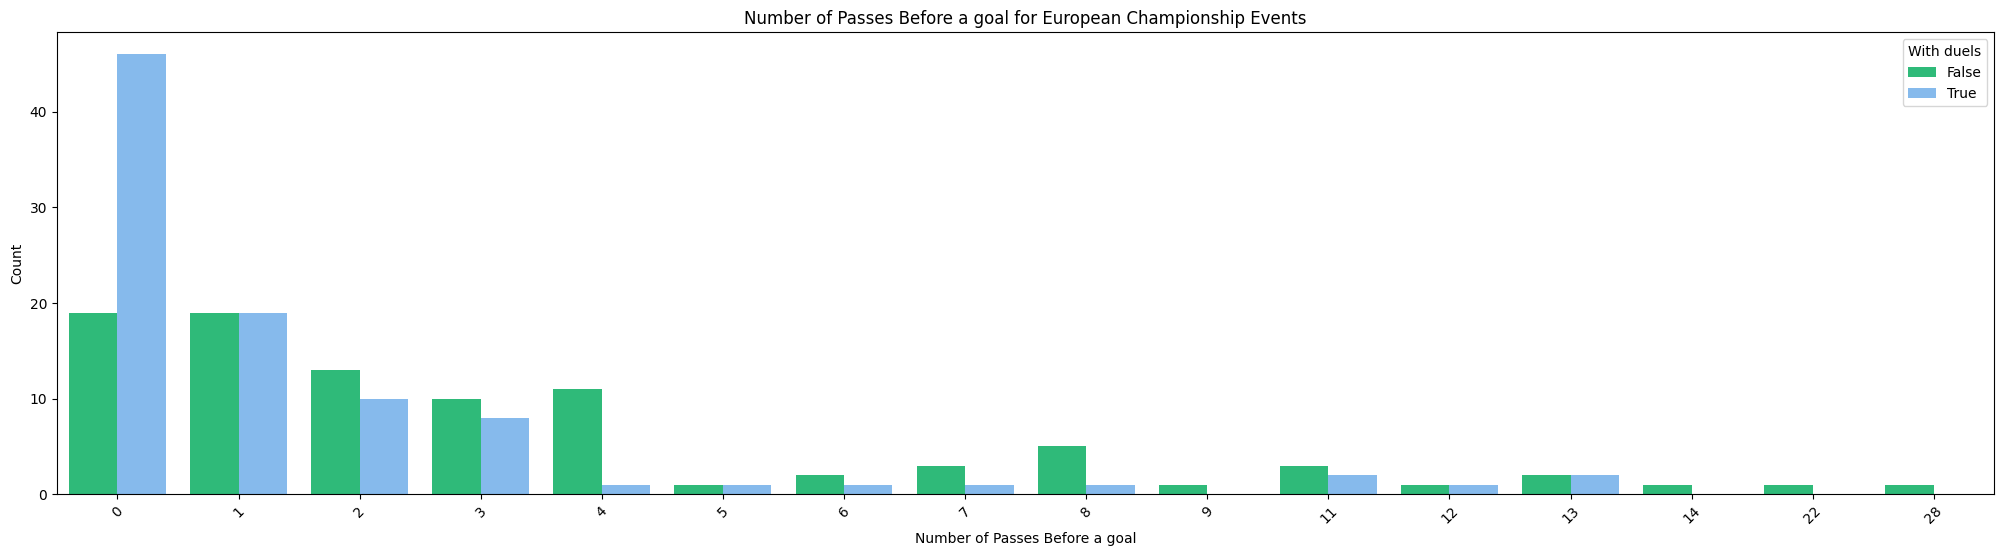

In [88]:
plot_histogram_pass_chain(european_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for European Championship Events')

### World Cup pass chain analysis

In [89]:
world_events = events_df['World_Cup']

In [90]:
passes_before_shot = get_passes_before_shot(world_events)
world_passes_counts = count_passes_before_shot(passes_before_shot)
world_passes_counts['duel'] = True

In [91]:
goals = world_events[world_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [92]:
passes_before_goal = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

In [93]:
world_goals_passes_counts = count_passes_before_shot(passes_before_goal)
world_goals_passes_counts['duel'] = True

I also remove these events to compare how the results change:
- >1,11,Duel,Ground attacking duel
- >1,12,Duel,Ground defending duel
- >1,13,Duel,Ground loose ball duel

In [94]:
world_events = world_events[(world_events['eventId'] != 1) & (~world_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

In [95]:
passes_before_shot_no_duel = get_passes_before_shot(world_events)
world_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

In [96]:
world_passes_counts_no_duels['duel'] = False

In [97]:
goals = world_events[world_events['tags'].apply(lambda x: 101 in x)]
goals = goals[goals['subEventName'] == 'Shot']

In [98]:
passes_before_goal_no_duel = {}
for index, row in goals.iterrows():
    match_id = row['matchId']
    event_sec = row['eventSec']
    
    passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

In [99]:
world_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
world_goals_passes_counts_no_duels['duel'] = False

In [100]:
world_passes_counts = pd.concat([world_passes_counts, world_passes_counts_no_duels])
world_goals_passes_counts = pd.concat([world_goals_passes_counts, world_goals_passes_counts_no_duels])

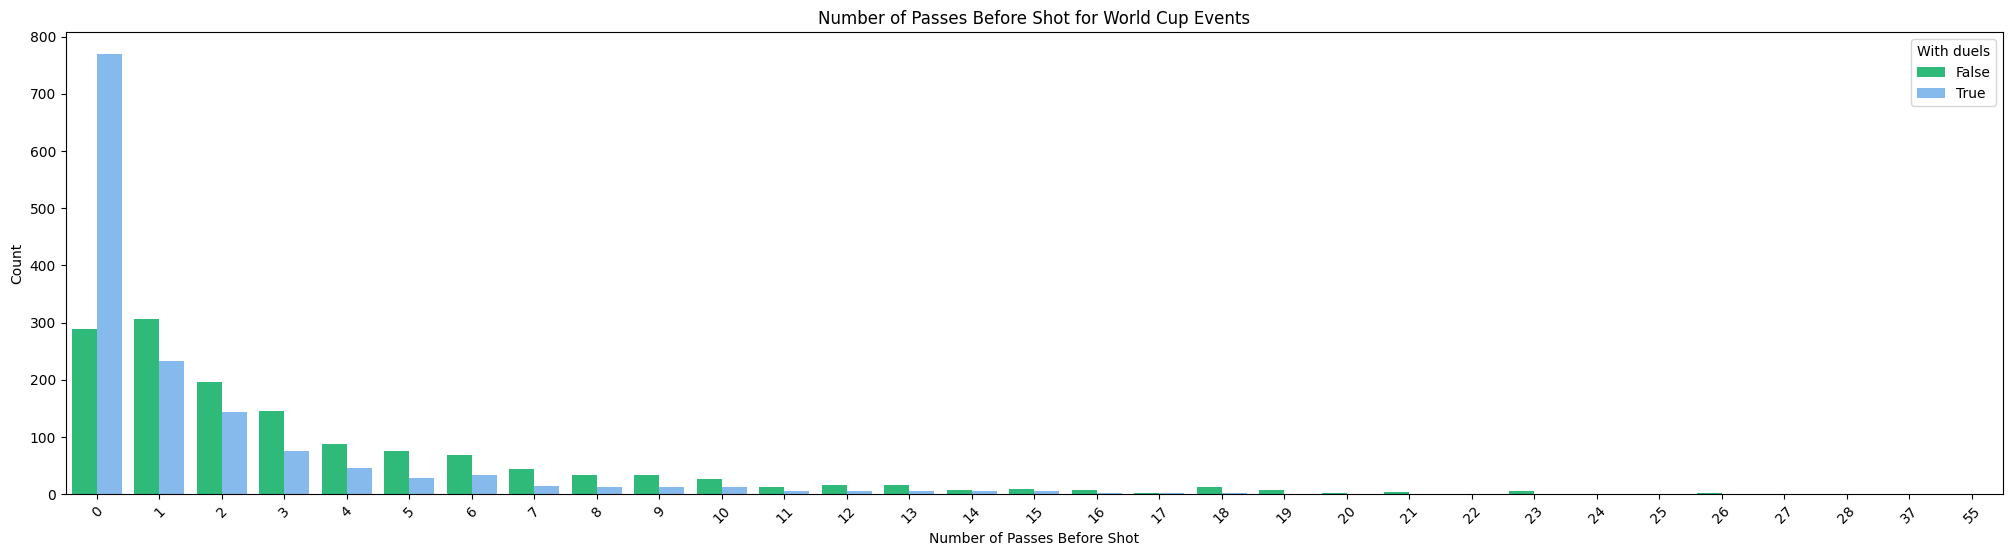

In [101]:
plot_histogram_pass_chain(world_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for World Cup Events')

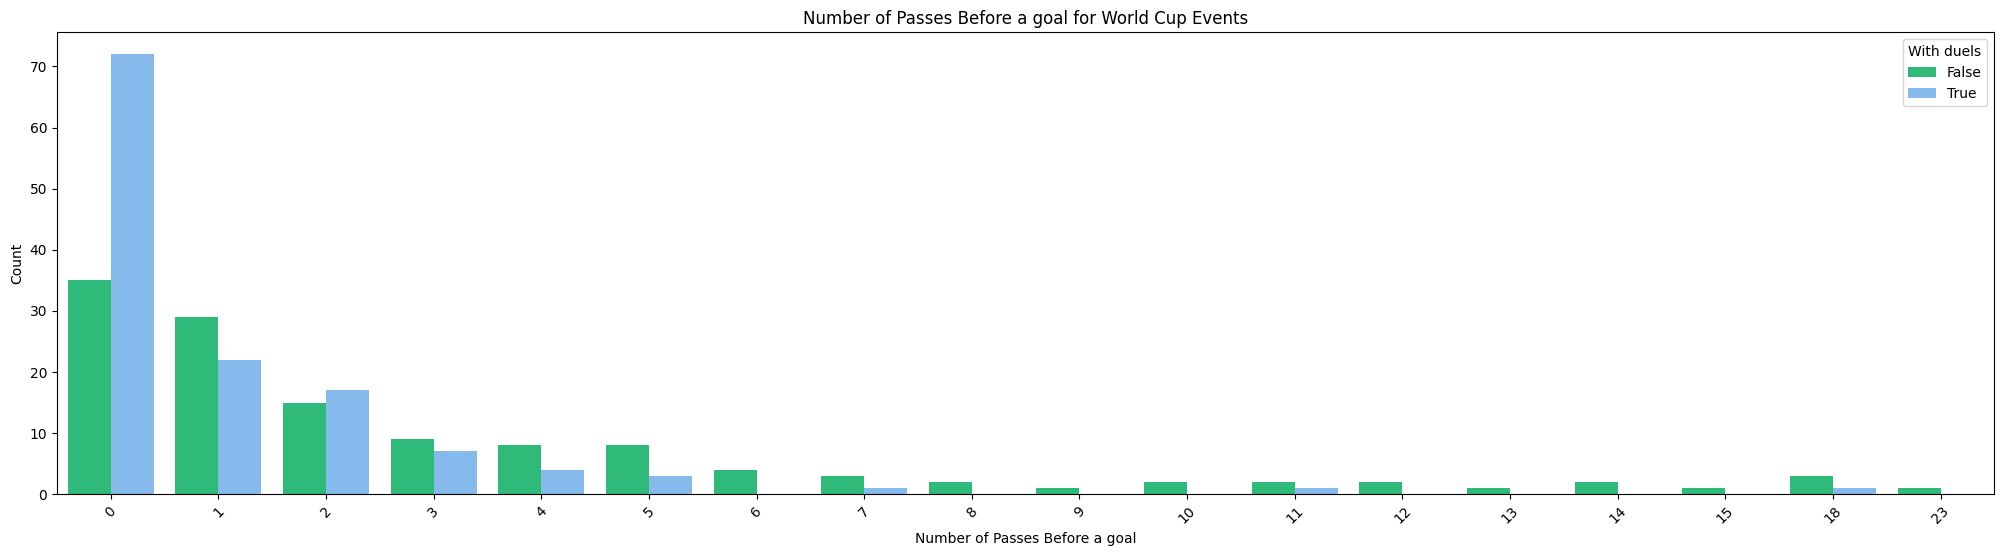

In [102]:
plot_histogram_pass_chain(world_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for World Cup Events')

### Total analysis

In [103]:
total_passes_counts = pd.concat([italian_passes_counts, english_passes_counts, spanish_passes_counts, german_passes_counts, french_passes_counts, european_passes_counts, world_passes_counts])
total_goals_passes_counts = pd.concat([italian_goals_passes_counts, english_goals_passes_counts, spanish_goals_passes_counts, german_goals_passes_counts, french_goals_passes_counts, european_goals_passes_counts, world_goals_passes_counts])

In [104]:
total_passes_counts = total_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()
total_goals_passes_counts = total_goals_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()

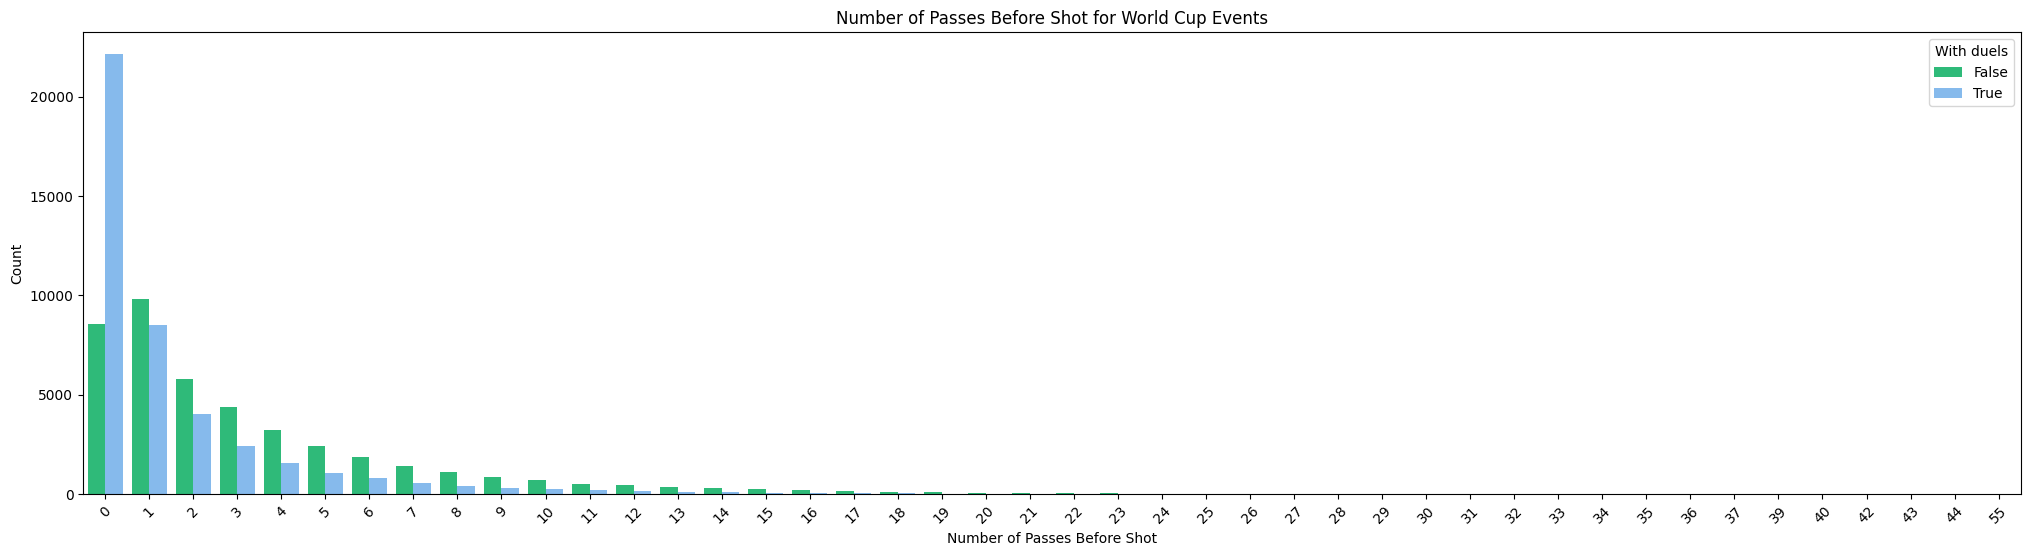

In [105]:
plot_histogram_pass_chain(total_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot for World Cup Events')

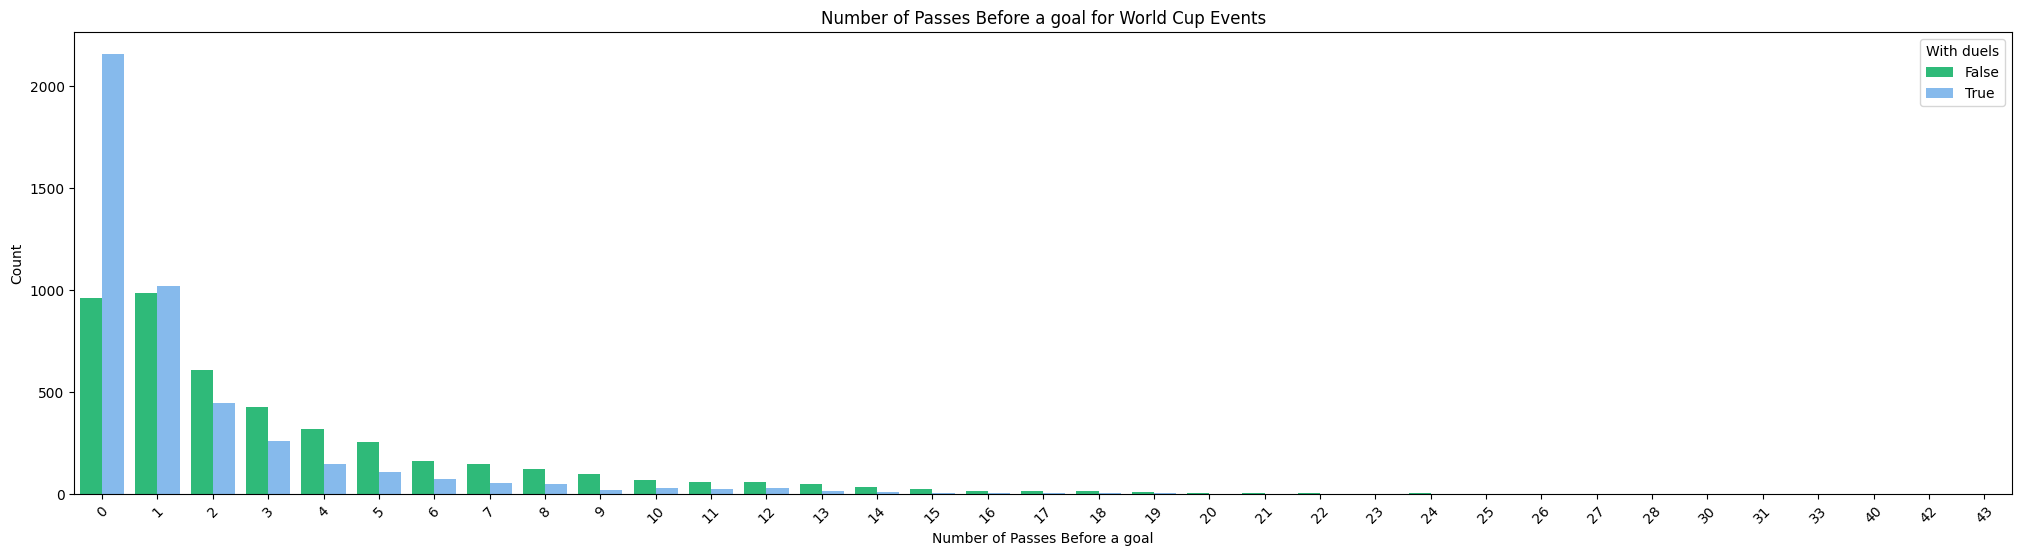

In [106]:
plot_histogram_pass_chain(total_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal for World Cup Events')